In [1]:
%load_ext autoreload
%autoreload 2 

In [6]:
# If on colab
!pip install latentshift

In [3]:
import io
import os,sys

import PIL
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
import latentshift
import taming

In [3]:
# This is needed until the library is merged into captum
# !pip uninstall captum -y 
!git clone https://github.com/ieee8023/captum

In [4]:
sys.path.insert(0,"captum")
import captum

In [5]:
ae = latentshift.autoencoders.VQGAN(weights="faceshq", download=True)
model = latentshift.classifiers.FaceAttribute(download=True)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


/home/users/joecohen/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/users/joecohen/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


In [13]:
!wget -q https://raw.githubusercontent.com/ieee8023/latentshift/main/sample_images/101.jpg -O 101.jpg

In [14]:
x = PIL.Image.open("./101.jpg").convert('RGB') 
x = torchvision.transforms.ToTensor()(x)[None,...]

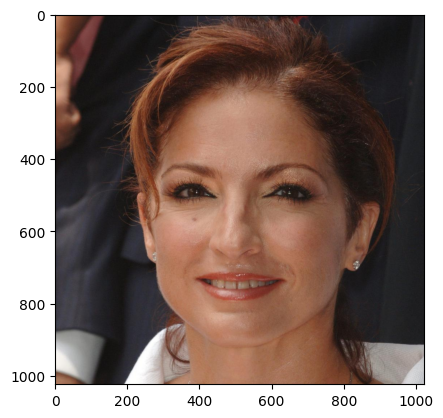

In [15]:
plt.imshow(x[0].permute(1, 2, 0).detach().numpy());

In [16]:
if torch.cuda.is_available():
    model = model.cuda()
    ae = ae.cuda()
    x = x.cuda()

In [17]:
model.targets

['blurry',
 'sideburns',
 'wearing_earrings',
 'bald',
 'goatee',
 'mustache',
 '5_o_clock_shadow',
 'arched_eyebrows',
 'no_beard',
 'heavy_makeup',
 'male',
 'wearing_lipstick',
 'black_hair',
 'high_cheekbones',
 'smiling',
 'mouth_slightly_open',
 'oval_face',
 'bushy_eyebrows',
 'attractive',
 'young',
 'gray_hair',
 'brown_hair',
 'blond_hair',
 'pale_skin',
 'chubby',
 'double_chin',
 'big_nose',
 'bags_under_eyes',
 'wearing_necklace',
 'wearing_necktie',
 'rosy_cheeks',
 'bangs',
 'wavy_hair',
 'straight_hair',
 'wearing_hat',
 'big_lips',
 'narrow_eyes',
 'pointy_nose',
 'receding_hairline',
 'eyeglasses']

In [18]:
target = model.targets.index("smiling")

Shift: 0, Pred: 0.9251331686973572, pixel_diff: 0.0, sum*diff_pct: 3019.021728515625
Shift: -10.0, Pred: 0.8847963213920593, pixel_diff: 90.34165954589844, sum*diff_pct: 3019.021728515625
Shift: -21.0, Pred: 0.8238264322280884, pixel_diff: 189.41702270507812, sum*diff_pct: 3019.021728515625
Shift: -34.0, Pred: 0.7319055795669556, pixel_diff: 305.49200439453125, sum*diff_pct: 3019.021728515625
Shift: -48.0, Pred: 0.587222158908844, pixel_diff: 429.1763000488281, sum*diff_pct: 3019.021728515625
Shift: -63.0, Pred: 0.4070218503475189, pixel_diff: 560.0990600585938, sum*diff_pct: 3019.021728515625
Shift: -80.0, Pred: 0.24203620851039886, pixel_diff: 705.2501220703125, sum*diff_pct: 3019.021728515625
Shift: -98.0, Pred: 0.1479111760854721, pixel_diff: 853.5813598632812, sum*diff_pct: 3019.021728515625
Shift: -118.0, Pred: 0.09649703651666641, pixel_diff: 1013.654052734375, sum*diff_pct: 3019.021728515625
Ending search: reached search_pred_diff of 0.8
Selected bounds:  -118.0 0
Lambdas to co

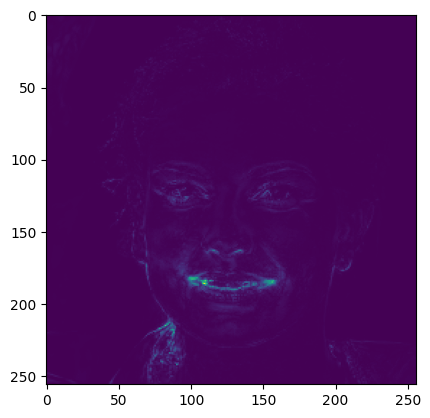

In [19]:
attr = captum.attr.LatentShift(model, ae)
output = attr.attribute(
    x, 
    target=target,
    return_dicts=True,
)[0]
plt.imshow(output['heatmap'].mean(0));

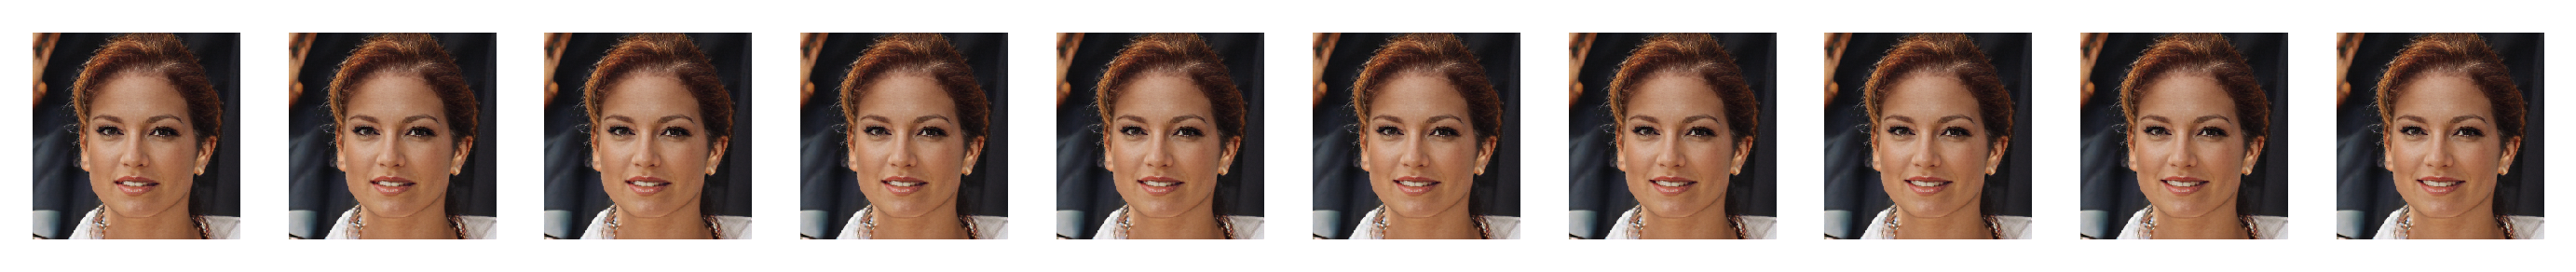

In [20]:
images_f = [h.transpose(1, 2, 0) for h in output["generated_images"]]
fig, axs = plt.subplots(ncols=len(images_f), squeeze=False, figsize=(8,3), dpi=350)
for i, img in enumerate(images_f):
    axs[0, i].imshow(img, interpolation='none')
    axs[0, i].axis('off');
plt.tight_layout()

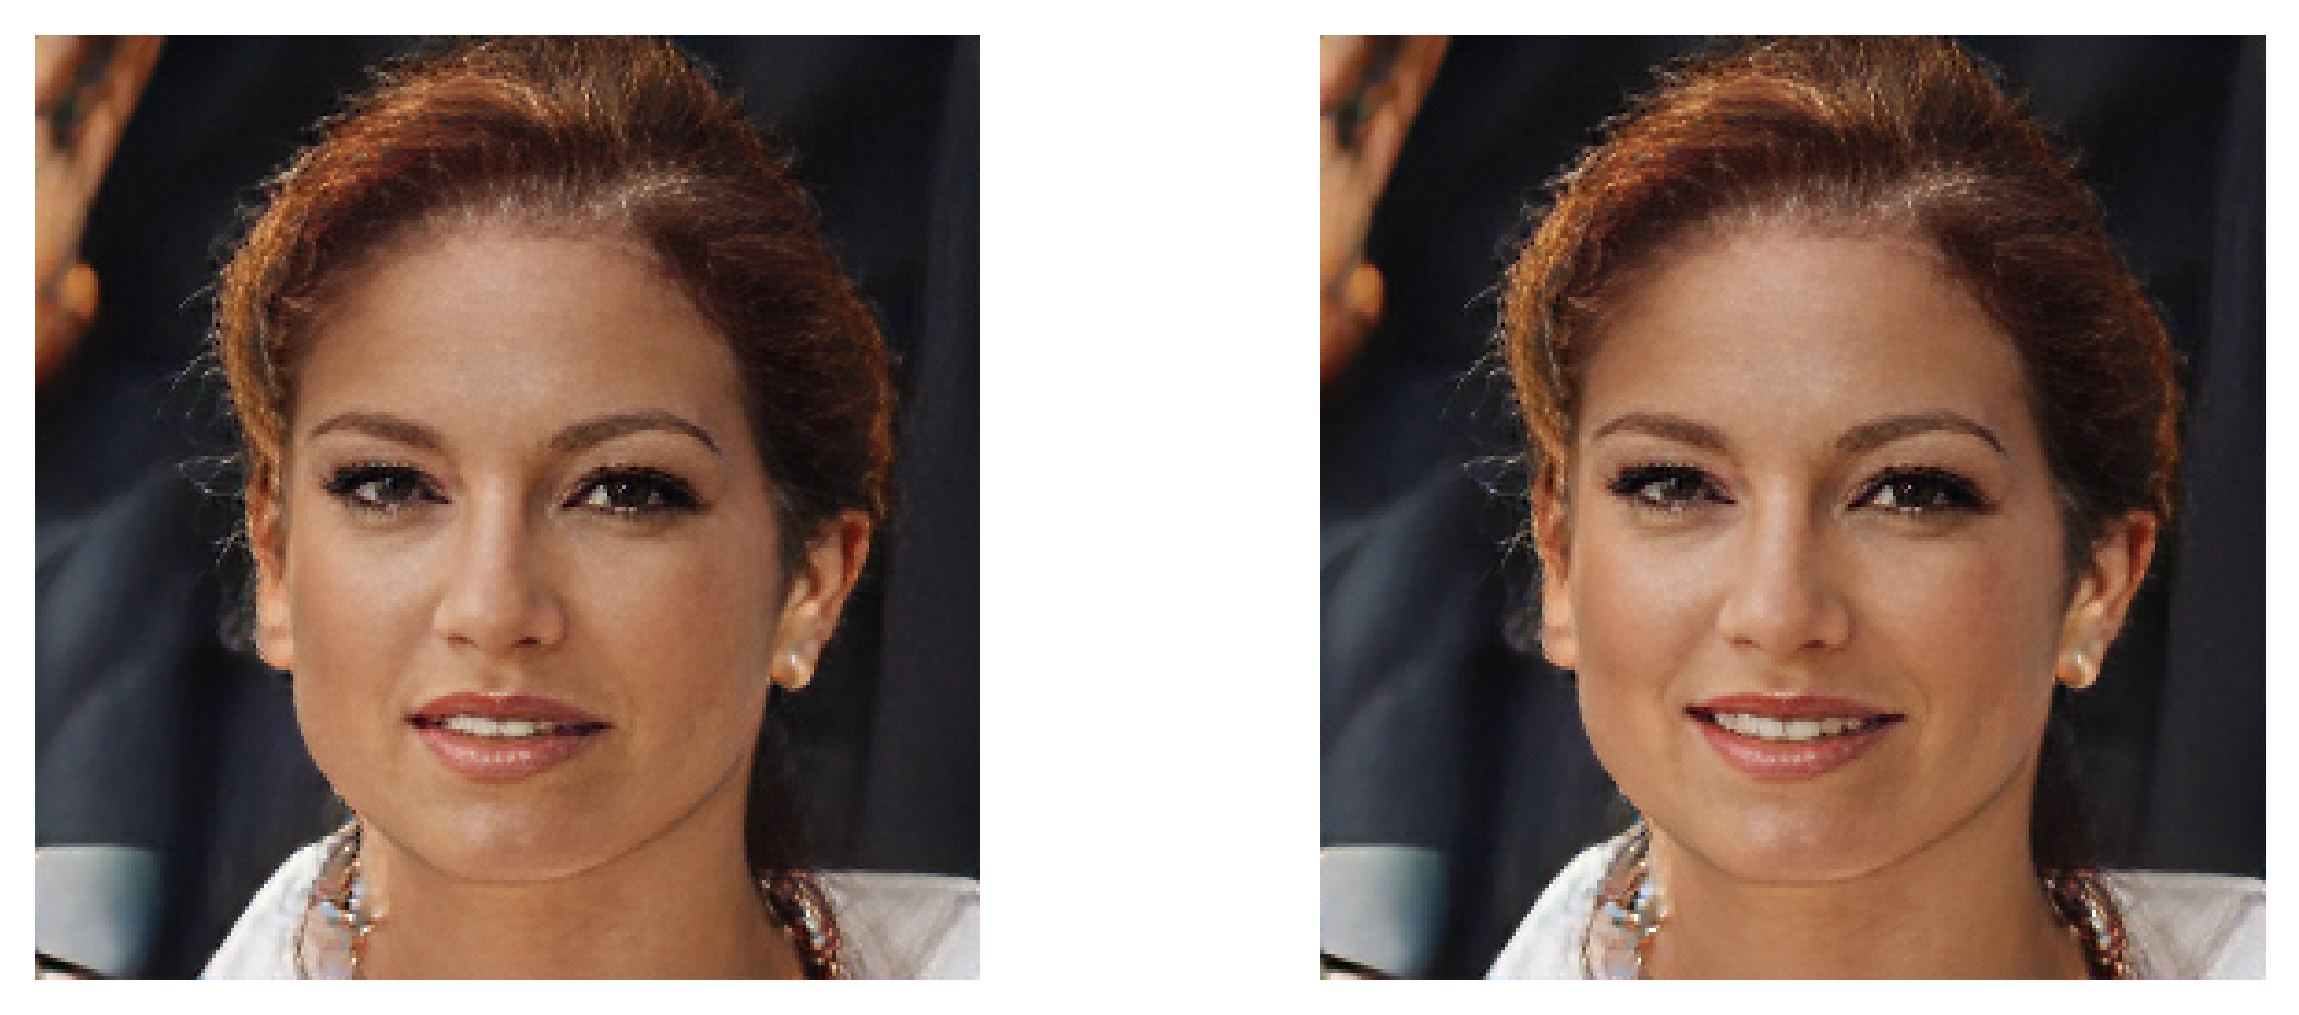

In [21]:
fig, axs = plt.subplots(ncols=2, squeeze=False, figsize=(8,3), dpi=350)
for i, img in enumerate([images_f[0], images_f[-1]]):
    axs[0, i].imshow(img, interpolation='none')
    axs[0, i].axis('off');
fig.tight_layout()

In [22]:
latentshift.video_utils.generate_video(output, "test")

ffmpeg -loglevel quiet -stats -y -i /tmp/gifsplanation/image-%d.png -c:v libx264 -vf scale=-2:256 -profile:v baseline -level 3.0 -pix_fmt yuv420p 'test.mp4'
b''


frame=   20 fps=0.0 q=28.0 Lsize=      16kB time=00:00:00.76 bitrate= 172.3kbits/s speed=6.55x    
